In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm
!pip install pillow==4.0.0

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59282000 @  0x7fcb249ea1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.5MB/s 
    100% |████████████████████████████████| 2.0MB 9.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 6.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
import os
import gzip
import tarfile
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils, datasets
import torchvision.models as models
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import matplotlib 
import copy
from matplotlib import pyplot as plt
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

from PIL import Image
import io
 
from google.colab import files
 
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])


class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to replace the relu functions with in place functions. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
          
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(x)  
    return self.intermediates
  
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    #print(features.size())
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    #print(input.size())
    #print(a*b*c*d)
    #print(G.size())
    return G.div(b* c * d)
 
  


In [2]:
print('Upload Content Image')
file_dict = files.upload()
content_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
 
print('\nUpload Style Image')
file_dict = files.upload()
style_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)

#vgg = models.vgg16(pretrained=True)
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]




Upload Content Image


Saving contentImage.png to contentImage (2).png

Upload Style Image


Saving styleImage.png to styleImage.png


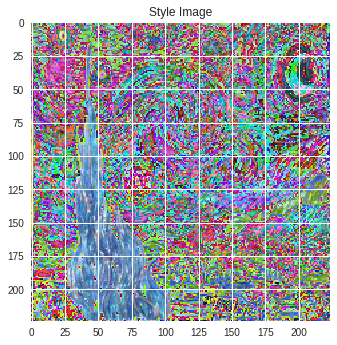

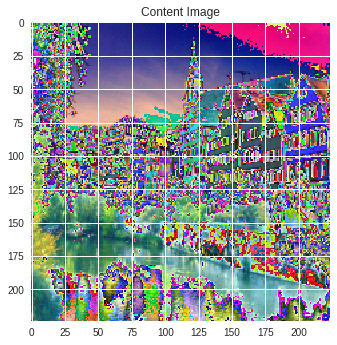

In [3]:
style_image=style_image.cuda()
content_image=content_image.cuda()
style_image=style_image.to(torch.float)
content_image=content_image.to(torch.float)

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


#plt.figure()
imshow(style_image, title='Style Image')

#plt.figure()
imshow(content_image, title='Content Image')

In [0]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target=target
    
  def forward(self, input):
    #print(input.size())
    #print(self.target.size())
    self.loss=F.mse_loss(input, self.target)
    #print(self.loss)
    return(self.loss)
  
class StyleLoss(nn.Module):
  def __init__(self, layers):
    super(StyleLoss, self).__init__()
    
    self.target = getGrams(layers)
    
  def forward(self, input):
    optim_grams = getGrams(input)
    for i in optim_grams.keys():
      if 'losses' in vars():
        losses=torch.add(losses, F.mse_loss(optim_grams[i], self.target[i]))
        #print(F.mse_loss(optim_grams[i], self.target[i]))
      else:
        losses=F.mse_loss(optim_grams[i], self.target[i])
    #print(losses)  
    return(torch.mean(losses)) ##for now, return the third loss arbitrarily since it doesn't make sense to average such ridiculously different values
  
class TotalLoss(nn.Module):
  def __init__(self, content_targ, style_targ):
    super(TotalLoss, self).__init__()
    #print(content_targ.size())
    self.contentLoss = ContentLoss(content_targ)
    self.styleLoss = StyleLoss(style_targ)
    self.lastContentLoss=0
    self.lastStyleLoss=0
    self.b=10000
    
  def forward(self, optim_image):
    optim_content, optim_style = getActivations(optim_image, vgg)

    #print(self.contentLoss(optim_content))
    #print(self.styleLoss(optim_style))
    self.lastContentLoss=self.contentLoss(optim_content.squeeze(0))
    self.lastStyleLoss = self.styleLoss(optim_style)
    return(self.lastContentLoss+ self.b* self.lastStyleLoss)
  
  def getLastContentLoss(self):
    return(self.lastContentLoss.item())
  
  def getLastStyleLoss(self):
    return(self.b*self.lastStyleLoss.item())
  
def getActivations(image, vgg):
  requested_vals=[0,5,10,17]
  layer = vgg(image)
  content_activation = layer[0]
  #print(content_activation.size())
  #print(layer)
  return(content_activation, layer)

def getGrams(layers):
  grams={}
  for i in layers.keys():
    grams[i]=gram_matrix(layers[i])
  return(grams)
  


    

torch.Size([1, 3, 224, 224])


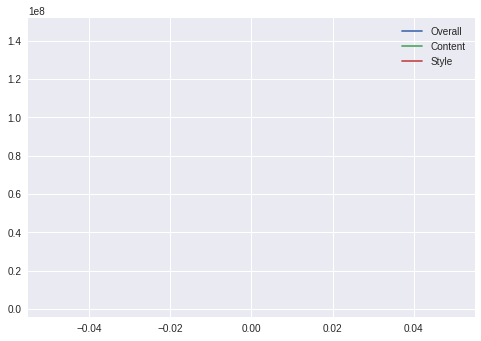

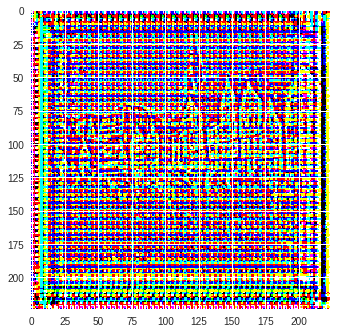

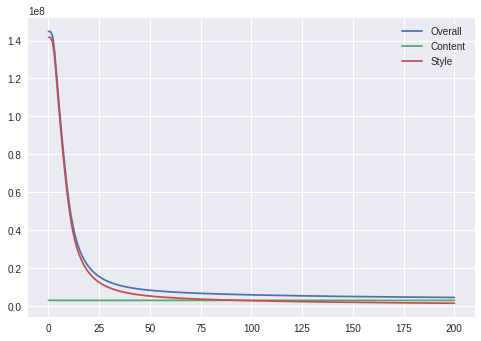

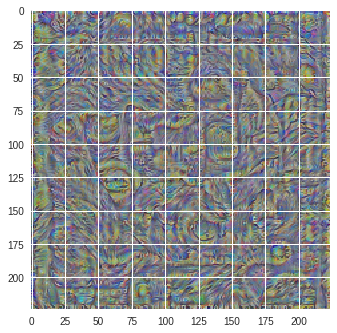

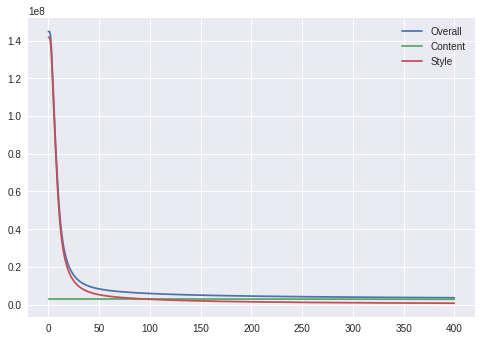

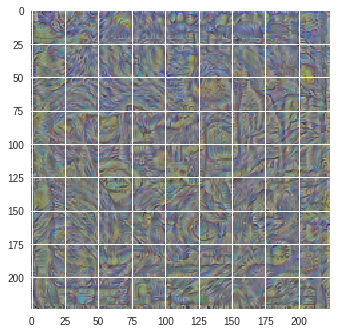

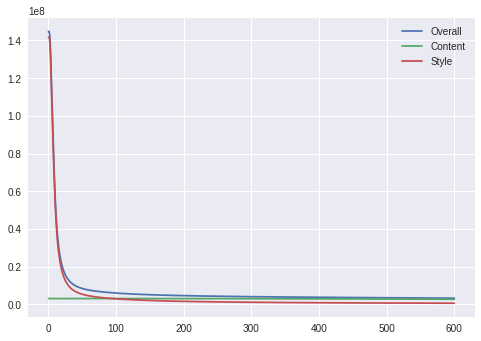

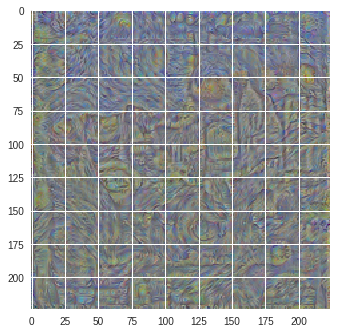

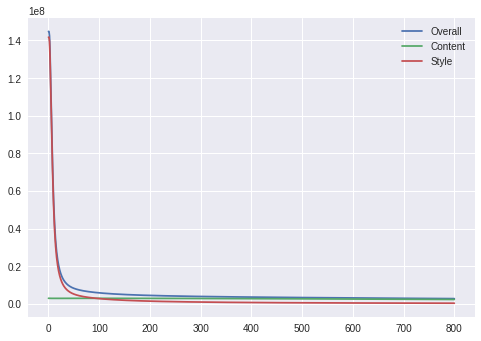

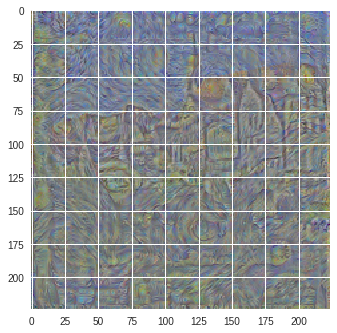

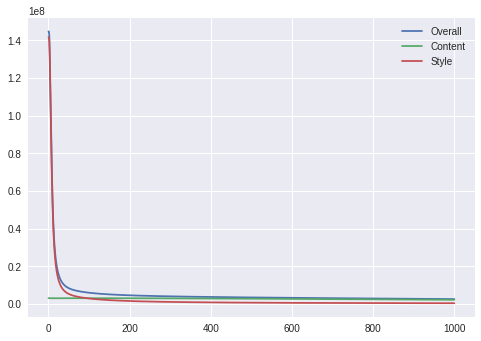

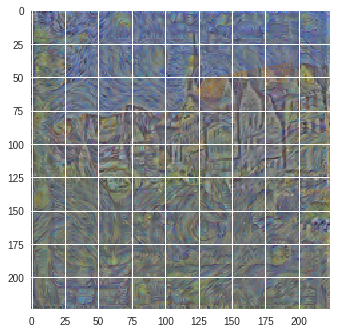

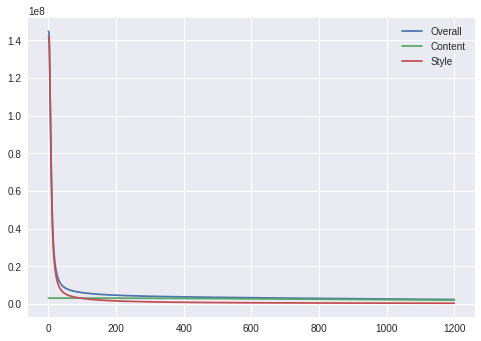

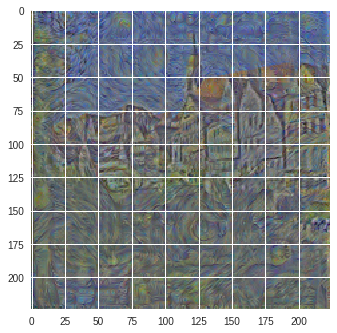

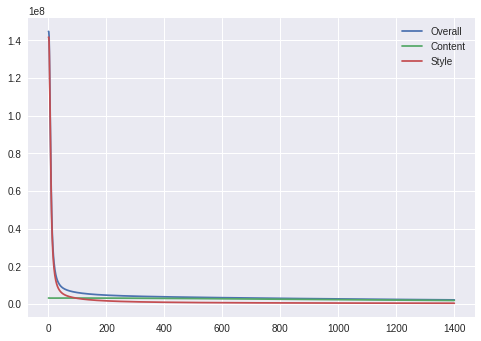

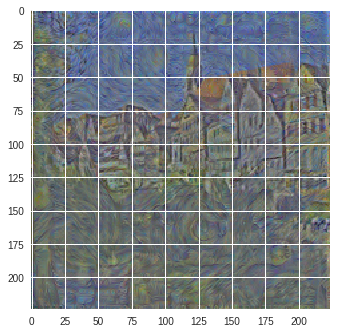

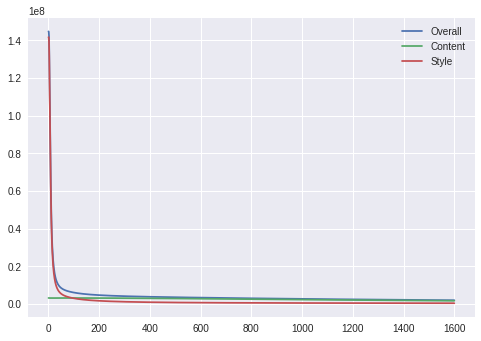

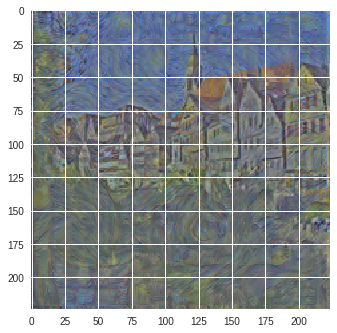

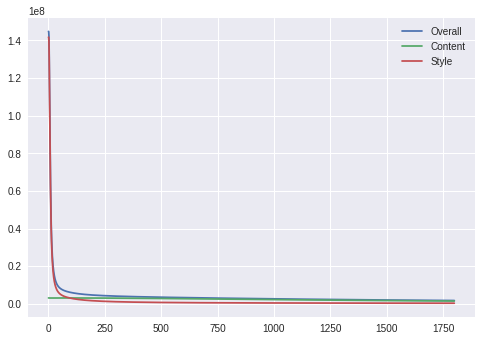

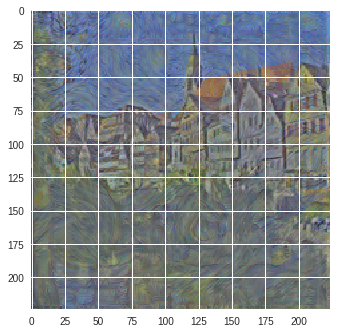

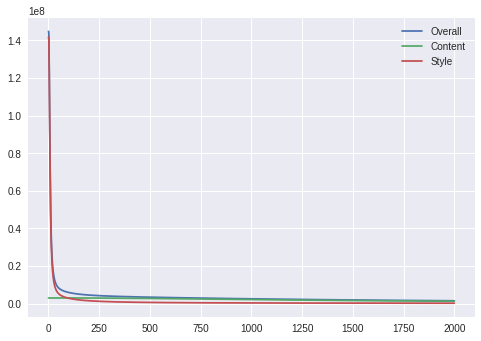

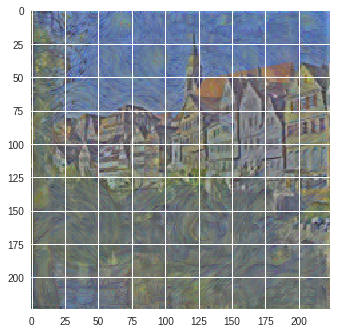

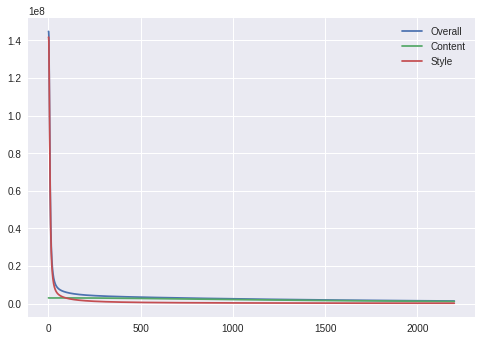

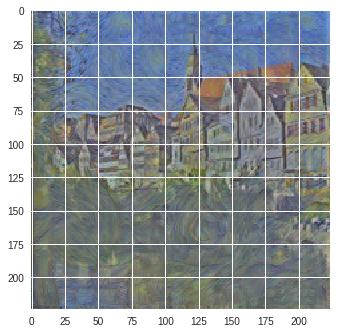

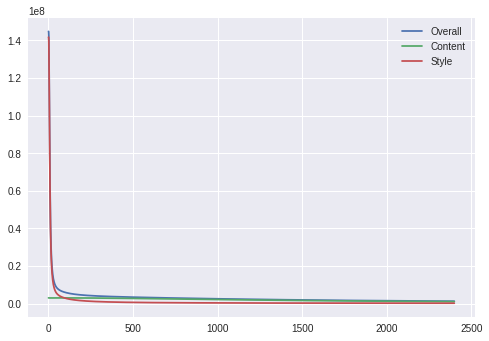

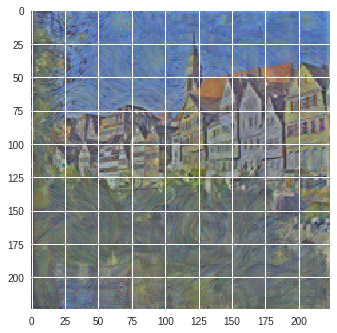

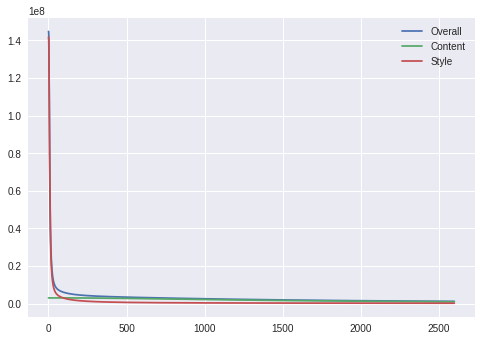

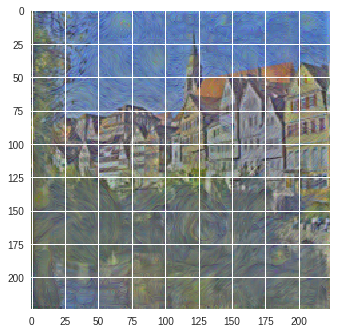

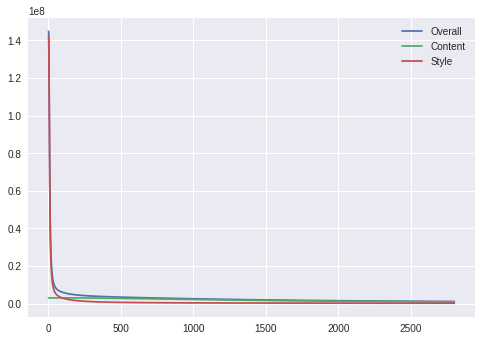

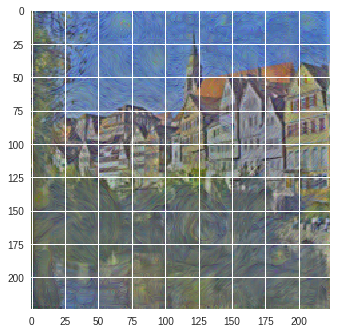

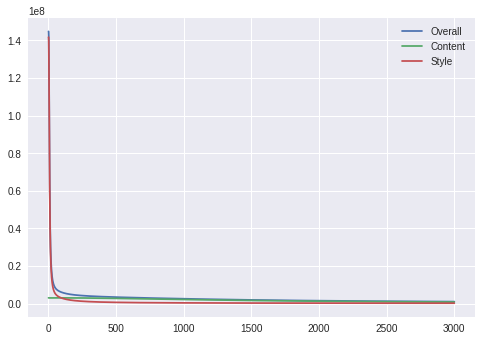

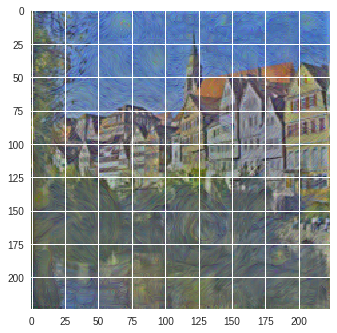

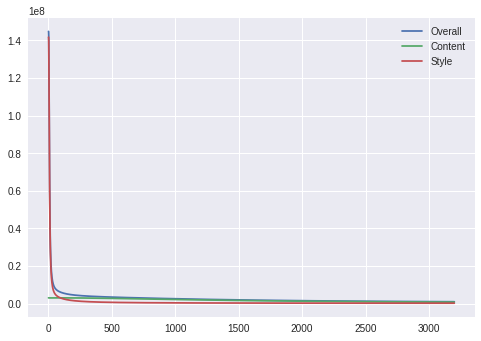

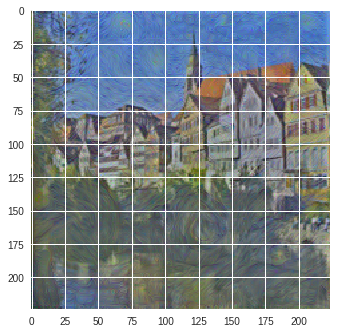

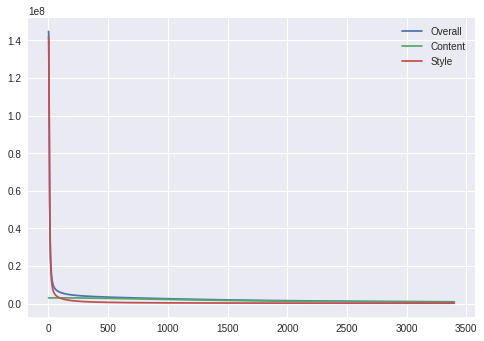

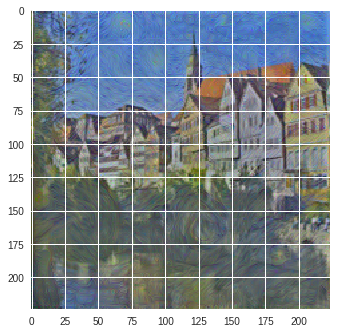

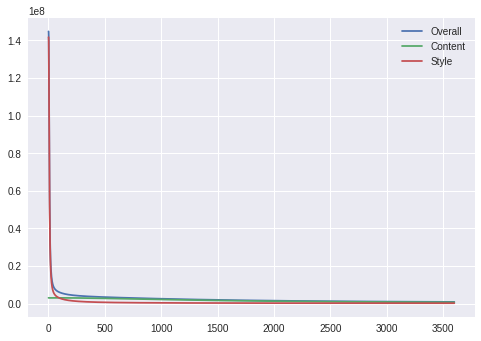

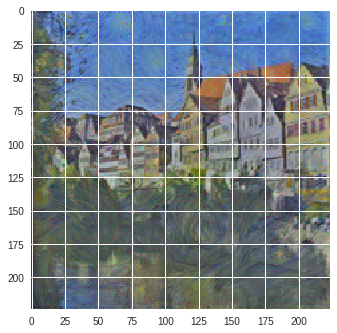

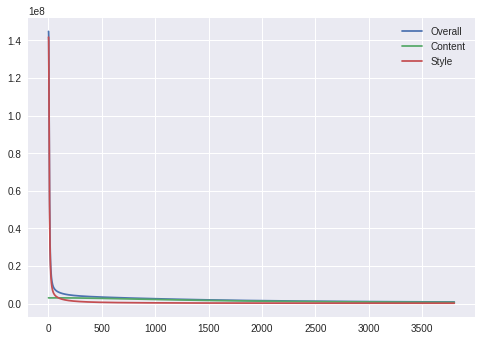

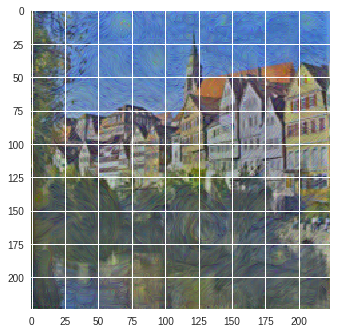

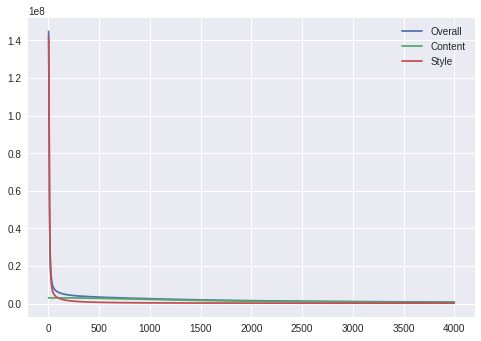

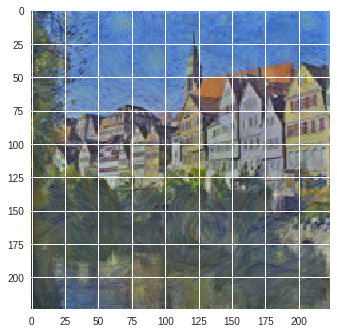

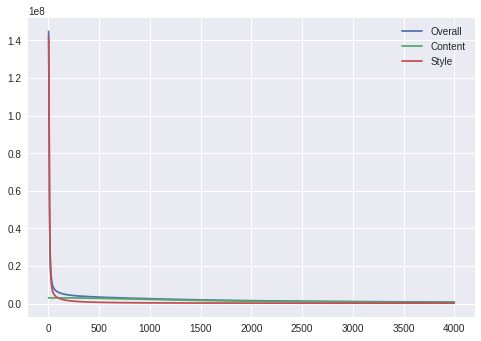

In [80]:
requested_vals=[0,5,10,17,24]
vgg = VGGIntermediate(requested=requested_vals)
vgg.cuda()
content_activation, trash = getActivations(content_image, vgg)
trash, style_activation = getActivations(style_image, vgg)

optim_image = torch.zeros(1,3, 224,224).cuda()#style_image.clone() ##Initialize the starting image
print(optim_image.size())
#print(optim_image==content_image)
#o_act, o_sty=getActivations(optim_image, vgg)
#print(torch.all(o_act==content_activation))
objective = TotalLoss(content_activation.squeeze(0), style_activation)
optimizer=optim.Adam([optim_image.requires_grad_()], lr=1e-2)

content_losses=[]
style_losses=[]
overall_loss=[]
for i in range(4001):
  optimizer.zero_grad()
  loss = objective(optim_image)
  loss.backward(retain_graph=True)
  optimizer.step()
  content_losses.append(objective.getLastContentLoss())
  style_losses.append(objective.getLastStyleLoss())
  overall_loss.append(loss.item())
  if i%200 ==0:
    plt.plot(overall_loss, label="Overall")
    plt.plot(content_losses, label="Content")
    plt.plot(style_losses, label="Style")
    plt.legend()
    plt.show()
    a=torch.sub(optim_image, torch.min(optim_image))
    a=torch.div(a, torch.max(a))
    imshow(a)

    
  #imshow(optim_image, title=i)
  
#print(content_activation.size())

#print(content_losses)
#print(style_losses)
plt.plot(overall_loss, label="Overall")
plt.plot(content_losses, label="Content")
plt.plot(style_losses, label="Style")
plt.legend()
plt.show()

#layer= vgg(style_image)
#style_activation = 
#style_activation


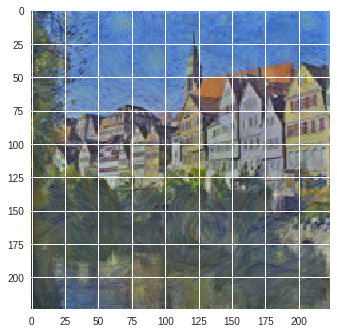

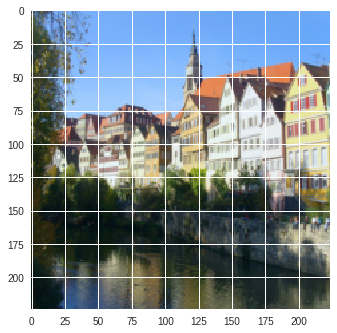

In [81]:

#plt.plot(overall_loss)
#plt.show()
a=torch.sub(optim_image, torch.min(optim_image))
a=torch.div(a, torch.max(a))

imshow(a)
b=torch.sub(content_image, torch.min(content_image))
b=torch.div(b, torch.max(b))
imshow(b)
#torch.min(content_image)
#imshow((content_image+torch.min(content_image))/torch.max(content_image))